# EMOTION IA

### DESCRIPCION DEL PROYECTO

La inteligencia artificial emocional o Emotion AI es una rama de la IA que permite que los ordenadores entiendan el lenguaje no verval
humano como las posturas corporales o expresiones faciales.

* El objetivo de este proyecto es clasificar las emociones de las personas en funcion de sus imagenes faciales.
* En este caso practico, asumiremos que trabajamos como consultores de IA / ML.
* Una empresa emergente de San Diego nos ha contratado para construir, entrenar e implementar un sistema que monitoriza automaticamente
las emociones y expresiones de las personas.
* El equipo ha recopilado mas de 20.000 imagenes faciales, con sus etiquetas de expresion facial asociadas y alrededor de 2.000 imagenes
con sus anotaciones faciales de puntos clave.


### PARTE 1: DETECCION DE PUNTOS FACIALES CLAVES

* En la parte 1, crearemos un modelo de aprendizaje profundo (Deep Learning) basado e la red neuronal convolucional y los bloques
residuales para predecir puntos claves faciales.
* El connjunto de datos consta de coordenadas x e y de 15 puntos clave faciales.
* Las imagenes de entrada son de 96*96 pixeles.
* Las imagenes constan de un solo canal de color (imagenes en escala de grises)

###  LIBRERIAS

In [323]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
#from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
#from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import keras

In [324]:
print("Pandas Versio: %s" % pd.__version__)
print("Numpy Version: %s" % np.__version__)
print("PIL Version: %s" % PIL.__version__)
print("OpenCV Version: %s" % cv2.__version__)
print("TensorFlow Version: %s" % tf.__version__)
print("Keras Version: %s" % keras.__version__)
print("Sklearn Version: %s" % sklearn.__version__)

Pandas Versio: 1.4.3
Numpy Version: 1.23.1
PIL Version: 9.2.0
OpenCV Version: 4.6.0
TensorFlow Version: 2.9.2
Keras Version: 2.9.0
Sklearn Version: 1.1.1


### IMPORTAMOS EL DATASET

In [325]:
path_data = "../dataset/EmotionIA/"

In [326]:
keyfacial_df = pd.read_csv(path_data + 'data.csv')

In [327]:
print("Shape of keyfacial_df : %s" % str(keyfacial_df.shape))
print("\n")
keyfacial_df.head()

Shape of keyfacial_df : (2140, 31)




left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   
3          65.225739          37.261774           32.023096   
4          66.725301          39.621261           32.244810   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   
3           37.261774                60.003339                39.127179   
4           38.042032                58.565890                39.621261   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   
3                72.314713                38.380967                 37.618643   
4                72.515926                39.884466                 36.982380   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   
2                 36.320968  ...   53.538947            60.822947   
3                 38.754115  ...   54.166539            65.598887   
4                 39.094852  ...   64.889521            60.671411   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   
3            72.703722             37.245496             74.195478   
4            77.523239             31.191755             76.997301   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   
2               47.274947               70.191789                  47.274947   
3               50.303165               70.091687                  51.561183   
4               44.962748               73.707387                  44.227141   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   
2                  78.659368   
3                  78.268383   
4                  86.871166   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  
2  144 142 159 180 188 188 184 180 167 132 84 59 ...  
3  193 192 193 194 194 194 193 192 168 111 50 12 ...  
4  147 148 160 196 215 214 216 217 219 220 206 18...  

[5 rows x 31 columns]

In [328]:
# Obtenemos informacion relevante del dataset
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [329]:
# Comprobamos si hay valores nulos en el dataset
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [330]:
# Chequeamos el tamaño de la imagen con la ultima columna del dataset Image
keyfacial_df['Image'].shape

(2140,)

In [331]:
""" 
Dado que los valores para la imagen se dan como cadenas separadas por espacios, 
separamos los valores usando '' como separador.
Luego convertimos esto en una matriz numerica usando np.fromstring 
y convierta la matriz ID obtenida en una matriz 2D de forma (96, 96)
"""
keyfacial_df['Image'] = keyfacial_df['Image'].apply(
    lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [332]:
# Obtener la dimensiones de la imagen 0
keyfacial_df['Image'][0].shape

(96, 96)

### TAREA 1 
* Obtener los valores promedio, minimo y maximo para `right_eye_center_x`.

In [333]:
min_rigth_eye_center_x = np.min(keyfacial_df['right_eye_center_x'])
max_rigth_eye_center_x = np.max(keyfacial_df['right_eye_center_x'])
mean_right_eye_center_x = np.mean(keyfacial_df['right_eye_center_x'])

print("rigth_eye_center_x")
print("Minimo: %s" % str(min_rigth_eye_center_x))
print("Maximo: %s" % str(max_rigth_eye_center_x))
print("Promedio: %s" % str(mean_right_eye_center_x))

rigth_eye_center_x
Minimo: 18.9226106286
Maximo: 42.495171727
Promedio: 29.640268564561495


In [334]:
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

### VISUALIZACION DE IMAGENES

1261


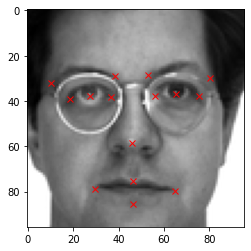

In [335]:
"""
Representamos una imagen aleatoria del conjunto de datos 
con puntos claves faciales.
Los datos de la imagen se obtienen del data['Image'] y 
se representan usando plt.imshow()
15 Coordenadas x e y para la imagen correspondiente.
Dado que las coordenadas x estan en columnas pares como 0,2,...
y las coordenadas y estan en columnas impares como 1,3,...
Accedemos a su valor usando el comando .loc que obtiene los valores
de las coordenadas de la imagen en funcion de la columna a la que refiere
"""

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
print(i)
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

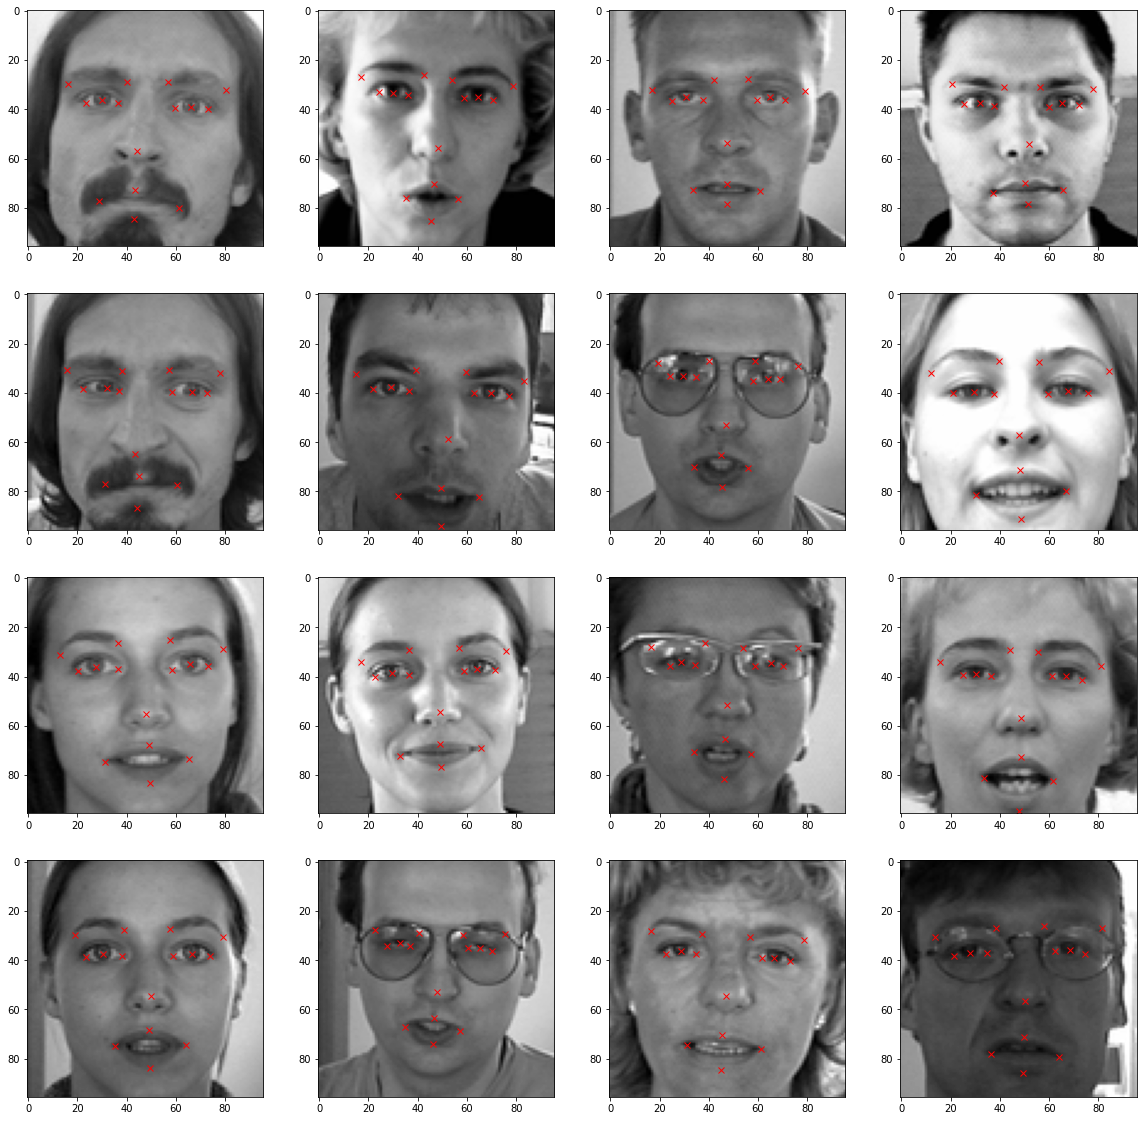

In [336]:
# Veamos mas imagenes en formato matricial
fig = plt.figure(figsize = (20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

### TAREA 2
* Realiza una verificacion adicional en los datos visualizando aleatoriamente 64 imagenes junto con sus puntos clave correspondientes

[1382, 934, 1613, 186, 1875, 399, 1798, 1459, 283, 751, 1572, 1960, 1922, 1900, 1984, 1189, 1155, 1745, 804, 1761, 1192, 1265, 254, 336, 2089, 1462, 628, 1522, 1353, 1990, 1708, 14, 881, 455, 442, 1423, 1417, 1967, 1053, 286, 863, 636, 984, 1620, 1855, 1005, 76, 1853, 403, 932, 1543, 1119, 1713, 1785, 1533, 172, 1956, 964, 1931, 413, 1833, 912, 1347, 1771]


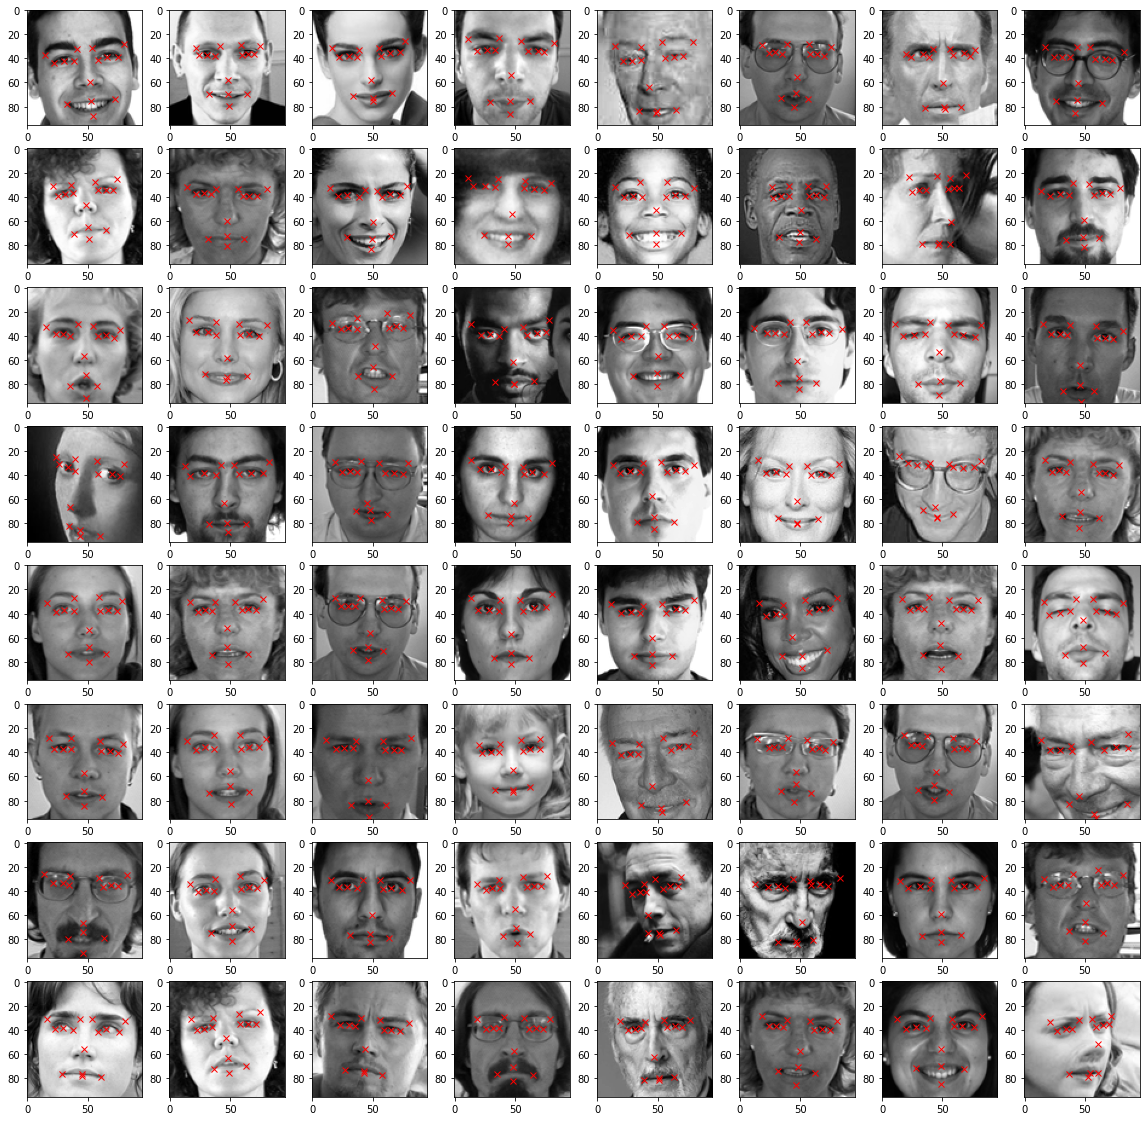

In [338]:
# Solucion TAREA 2
fig = plt.figure(figsize = (20, 20))

list_images = []
for i in range(64):
    k = np.random.randint(1, len(keyfacial_df))

    while list_images.count(k) > 0: 
        k = np.random.randint(1, len(keyfacial_df))
    
    list_images.append(k)
    ax = fig.add_subplot(8, 8, i + 1)    
    plt.imshow(keyfacial_df['Image'][k], cmap = 'gray')
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')

print(list_images)

### AUMENTACION DE IMAGENES

La aumentacion de imagenes es para crear un dataset adicional, que en lugar de que utilize unicamente los datos del dataset
de entrada que hemos cargados. Utiliza los datos del dataset de entrada, vamos a crear un nuevo dataset tomando las imagenes que tiene el dataset de entrada, vamos a girar las imagenes, incrementar el brillo o reducir el brillo, zoom. Haciendo esto vamos a conseguir algo muy importante en las redes
neuronales que trabajan con imagenes, vamos a mejorar la generalizacion, la compatilibiladad de que el modelo trabaje bien, que es una caracteristica
ensencial en los modelos de inteligencia artificial.

In [345]:
# Creamos una copia del dataframe
import copy

keyfacial_df_copy = copy.copy(keyfacial_df)

# Obtenemos las columnas del dataframe
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [346]:
# Horizontal Flip - Damos vuelta a las imagenes en entorno al eje y
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(
    lambda x: np.flip(x, axis = 1))

# Dado que estamos volteando horizontalmente. los valores de la 
# coordenada y serian los mismos
# Solo cambiarian los valores de la coordenada x, todo lo que tenemos
# que hacer es restar nuestros valores iniciales de la coordenada x
# del ancho de la imagen(96)
for i in range(len(columns)):
    if i%2 == 0:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(
            lambda x: 96. - float(x))

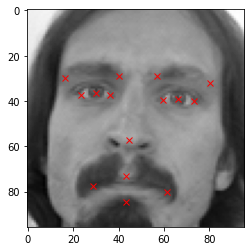

In [347]:
# Mostramos la imagen original
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')

for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')


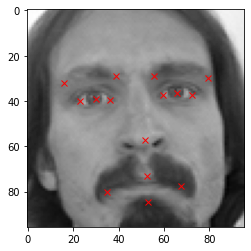

In [348]:
# Mostramos la imagen girada horizontalmente
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')

for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [349]:
# Concatenamos el dataset original con el dataframe aumentado
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augmented_df.shape

(4280, 31)

In [350]:
# Aumentar aleatoriamente el brillo de las imagenes
# Multiplicamos los valores de los pixeles por valores aleatorios entre 1,5 y 2
# para aumentar el brillo de la imagen
# Recortamos el valor entre 0 y 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(
    lambda x: np.clip(random.uniform(1.5, 2) * x, 0.0, 255.0))

augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

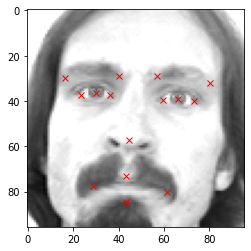

In [351]:
# Mostramos la imagen con aumento de brillo 
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')

for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

### TAREA 3
* Aumenta las imagenes volteandolas verticalmente (Sugerencia: voltea a lo largo del eje x y teng en cuenta que si lo hacemos a lo largo
del eje x las coordenadas x no cambiaran)

### TAREA 4
* Visualiza los resultados

(8560, 31)

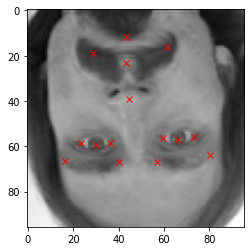

In [352]:
keyfacial_df_copy = copy.copy(keyfacial_df)

# Obtenemos las columnas del dataframe
columns = keyfacial_df_copy.columns[:-1]

# Vertical Flip - Damos vuelta a las imagenes en entorno al eje x
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(
    lambda x: np.flip(x, axis = 0))

# Dado que estamos volteando verticalmente. los valores de la 
# coordenada x serian los mismos
# Solo cambiarian los valores de la coordenada y, todo lo que tenemos
# que hacer es restar nuestros valores iniciales de la coordenada y
# del ancho de la imagen(96)
for i in range(len(columns)):
    if i%2 == 1:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(
            lambda x: 96. - float(x))

# Mostramos la imagen girada verticalmente
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')

for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

# Concatenamos el dataset
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

### NORMALIZACION DE LOS DATOS Y PREPARACION PARA EL ENTRENAMIENTO

In [353]:
"""
Obtenemos el valor de las imagenes que esta presente en la columna 31 (dado que
el indice comienza desde 0, nos referimos a la columna 31 por 30 en python)
"""
img = augmented_df[:,30]

# Normalizamos las imagenes
img = img / 255.

# Creamos un array vacio de tamaño (x,96,96,1) para sumunistrar al modelo
X = np.empty((len(img), 96, 96, 1))

# Iteramos sobre la lista de imagenes y añadimos las nusnas ak array vacio
# tras expandir su dimencion de (96,96) a (96,96,1)
for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis = 2)

# Convertimos el tipo array a float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [354]:
# Obtenemos el valor de las coordenadas x & y que se utilizaran como tarjet
y = augmented_df[:, :30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [355]:
# Dividimos los datos en entrenamiento y testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### TAREA 5
* Intentar usar un valor diferente para `test_size` y verifica que la division es correcta

In [356]:
print("x_train shape: %s" % str(x_train.shape))
print("x_test shape: %s" % str(x_test.shape))

x_train shape: (6848, 96, 96, 1)
x_test shape: (1712, 96, 96, 1)


### ENTENDER LA TEORIA E INTUICION DE LAS REDES NEURONALES

* El cerebro tiene mas de 100 mil millones de neuronas que se comunican a atraves de señales electricas y quimicas.
Las neuronas se comunican entre si y nos ayudan a ver, pensar, etc
* El cerebro humano aprende creando conexiones entre estas neuronas. Las RNA son modelo de procesamiento de informacion
inspirados en el cerebro humano
* La neurona recolecta señales de los canales de entradas llamados dentritas, procesa la infomacion en su nucleo y 
luego genera una salida en una rama larga y delgada llamada axon
* El sesgo o bias permite cambiar la curva de la funcion de activacion hacia arriba o abajo.
* Numero de parametros ajustables = 4 (3 pesos y 1 bias)
`y=f(x1.w1 + x2.w2 + x3.w3 + b)` las Xi son los inputs y los Wi son los pesos.

### TAREA 6
* Lista al menos 3 funciones diferentes de activacion e indica cual es el tipo preferido para usar en las capas ocultas

* 1- Funcion sigmoide -> toma numberos y devuelve un valor entre 0 y 1, convierte numeros negativos muy pequeños a 0 y numeros positivos muy grandes a 1, 
generalmente se usa en la capa de salida (output layer)
* 2- Funcion Relu -> si el input x < 0, la salida es 0 y si x > 0 la salida es x.
Es usada en limites simples debido a su eficiencia computacional, se usa generalmente en las capas ocultas (hidden layer).
* 3- Funcion Tangente Hiperbolica -> es similar a la funcion sigmoide pero el rango de valores es de -1 a 1

#### RED PERCEPTRON DE MULTIPLES CAPAS

* Conectemos varias de esta neuronas de forma multicapa.
* Cuantas mas capas ocultas, mas profunda se volvera la red

### TAREA 7
* Lista almenos 3 redes neuronales diferentes y sus respectivas aplicaciones.

##### Resolucion
- Red Neuronal Artificial -> Una sola neurona puede verse como una regresion logistica, pero la Red Neuronal Artificial es un grupo de multiples neuronas
en cada capa, esta red neuronal se conoce tambien como Feed-Forward Neural Network ya que la entradas solo se procesan en la direccion de avance. Esta se divide en 3 capas, la capa de entrada acepta los inputs, la capa oculta procesa estos inputs y la capa de salida produce el resultado. La RNA es capaz de aprender cualquier funcion no lineal gracias a las funciones de activacion, estas introducen propiedades no lineales a la red y esto ayuda a aprender cualquier relacion completa entre la entrada y salida.

- Red Neuronal Recurrente -> A diferencia de la RNA, la red recurrente tiene una conexion recurrente en la capa oculta, esta restriccion de bucle garantiza que la informacion secuencial se capture en los datos de entrada.

- Red Neuronal de Convolucion -> Estas redes estan de moda en la comunidad de Deep Learning en la actualidad. Estos modelos de RNC se utilizan en diferentes aplicaciones y son muy frecuentes en proyecto de procesamiento de imagenes y videos. Los componentes principales de las CNN son filtros o conocidos como nucleos o convoluciones. Estas convoluciones se utilzan para extraer caracteristicas relevantes de la entrada mediante la operacion de Convolucion. Convolucionar una imagen da como resultado un mapa de caracteristicas o mejor dicho un feature_map

### ENTENDER EL ENTRENAMIENTO EN REDES Y LOS ALGORITMOS DE GRADIENTE DESCENDENTE

#### Division de datos en training y testing

* El conjunto de datos generalmente se divide en 80% para entrenamiento y 20% para pruebas.
* A veces, tambien podemos incluir un conjunto de datos validacion cruzada y luego lo dividimos en segmentos de 60%, 20%, 20% para entrenamiento, validacion y prueba respectivamente.
    * Conjunto de entrenamiento: se utiliza para calcular el gradiente y actualizar los pesos de la red.
    * Conjunto de validacion: utilizado para la validacion cruzada para evaluar la calidad del entrenamiento. La validacion cruzada se implementa para superar el overfitting que se produce cuando el algoritmo se centra en los detalles del conjunto de entrenamiento a costa de perder capacidad de generalizacion.
    * Conjunto de pruebas: usado para probar la red entrenada

#### Gradiente Descendente

* El gradiente descendente es un algoritmo de optimizacion que se utiliza para obtener el peso de red optimizado y los valores del bias.
* Funciona intentando minimizar de forma iterativa la funcion de coste.
* Funciona calculando el gradiente de la funcion de costes y moviendose en la direccion negativa hasta que se alcanza el minimo local / global.
* Si se toma el valor positivo del gradiente, se alcanza el maximo local / global.
* El tamaño de los pasos dados a cada iteracion se llama tasa de aprendisaje.
* Si la tasa de aprendizaje aumenta, el area cubierta en el espacio de busqueda aumentara para que podamos alcanzar el minimo global mas rapido.
* Para tasas de aprendizaje pequeñas, el entrenamiento llevara mucho mas tiempo para alcanzar valores de peso optimizado.

#### TAREA 8:
* Que ocurre cuando configuramos el ratio de aprendizaje (learning rate) a los valores extremos (valores muy pequeños y valores muy grandes)?
Como se puede conseguir el mejor resultado de ambos escenarios?

`Un learning rate con un valor demasiado alto implica que el modelo converge de forma muy rapida obteniendo un resultado no optimo mientras que un learning rate con un valor demasiado pequeño hace que el proceso de convergencia tarde mas tiempo. Por lo cual una solucion para este problema es el Gradiente Descendente Estocasico que basicamente se trata de un learning rate dinamico de modo que se empieza con un valor original para el learning rate, empezariamos con un valor alto al principio y luego seria dinamico multiplicando por un valor en cada iteracion haciendo que el learning rate sea mas pequeño en cada iteracion`


### ENTENDER LA TEORIA E INTUICION DETRAS DE LAS REDES NEURONALES CONVOLUCIONALES Y RESNETS

### RESNET (REDES RESIDUALES)

* A medida que las redes neuronales convolucionales (RNC) se hacen mas profundas, tienden a ocurrir el desvanecimiento del gradiente que impacta negativamente en el rendimiento de la red
* El problema del desvanecimiento del gradiente ocurre cuando el gradiente se propaga hacia atras a capas anteriores, lo que da como resultado un gradiente muy pequeño
* La red neuronal residual incluye la funcion de "omision sin conexion" que permite el entrenamiento de 152 capas sin el problema del desvanecimiento del gradiente
* ResNet funciona agregando "asignaciones de identidad" en la parte superior de la RNC
* ImageNet contiene 11 millones de imagenes y 11.000 categorias
* ImageNet se utiliza para entrenar la red profunda de ResNet

### TAREA 9
* ¿Cual es la eficacia de las ResNets comparada con AlexNet en datasets de ImageNet?

La eficacia de ResNet sobre AlexNet radica en la profundidad de las redes ya que AlexNet tiene una profundidad de 8 capas ocultas convolucionales y ResNet tiene una profundidad de 152 capas ocultas convolucionales. Sin embargo aumentar la profundidad de una red neuronal no es solo apilar capas una detras de otra ya que estas redes son dificiles de entrenar debido al desvanecimiento del gradiente, ya que el gradiente se propaga hacia atras  a las capas anteriores, dado que la multiplicacion repetida puede hacer que el valor del gradiente sea muy pequeño y como resultado provoca que la red se sature o que comienze a degradarse rapidamente.
##### Omitir conexion: la fuerza de ResNet
Para resolver el problema del gradiente de fuga / explosión, esta arquitectura introdujo el concepto llamado Red residual. En esta red usamos una técnica llamada salto de conexiones . La conexión de salto omite el entrenamiento de algunas capas y se conecta directamente a la salida.

Estas son las ventajas de ResNet sobre AlexNet

### CONSTRUIR UN MODELO DE RED NEURONAL RESIDUAL PROFUNDA PARA CREAR UN MODELO QUE DETECTE PUNTOS FACIALES CLAVE

In [357]:
def residual_block(X, filter, stage):
    # Bloque Convolucional
    X_copy = X 
    
    f1, f2, f3 = filter

    # Camino Principal
    X = Conv2D(f1, kernel_size = (1, 1), strides = (1, 1), name = 'res_' + str(stage) + '_conv_a', 
        kernel_initializer = glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2, 2))(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, kernel_size = (3, 3), strides = (1, 1), padding = 'same', 
        name = 'res_' + str(stage) + '_conv_b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size = (1, 1), strides = (1, 1), name = 'res_' + str(stage) + '_conv_c',
        kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_c')(X)

    # Camino Corto
    X_copy = Conv2D(f3, kernel_size = (1, 1), strides = (1, 1), name = 'res_' + str(stage) + '_conv_copy', 
        kernel_initializer = glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2, 2))(X_copy)
    X_copy = BatchNormalization(axis = 3, name = 'bn' + str(stage) + '_conv_copy')(X_copy)

    # Añadir 
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Bloque de Identidad 1
    X_copy = X

    # Camino Principal
    X = Conv2D(f1, (1,1),strides = (1,1), name = 'res_' + str(stage) + '_identity_1_a',
        kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_' + str(stage) + '_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name = 'res_' + str(stage) + '_identity_1_b', 
        kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_' + str(stage) + '_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name = 'res_' + str(stage) + '_identity_1_c', 
        kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_' + str(stage) + '_identity_1_c')(X)

    # Añadir
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Bloque de Identidad 2
    X_copy = X


    # Camino Principal
    X = Conv2D(f1, (1,1),strides = (1,1), name = 'res_'+str(stage) + '_identity_2_a',
        kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name = 'res_' + str(stage) + '_identity_2_b',
        kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_' + str(stage) + '_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name = 'res_' + str(stage) + '_identity_2_c',
        kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_' + str(stage) + '_identity_2_c')(X)

    # Añadir
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [358]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero Padding 
X = ZeroPadding2D((3, 3))(X_input)

# 1 - Fase
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', 
    kernel_initializer = glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides = (2, 2))(X)

# 2 - Fase
X = residual_block(X, filter = [64, 64, 256], stage = 2)

# 3 - Fase 
X = residual_block(X, filter = [128, 128, 512], stage = 3)

# 4 - Fase
#X = residual_block(X, filter = [256, 256, 1024], stage = 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Average_Pooling')(X)

# Capa Final
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)

model_1_facialKeyPoints = Model(inputs = X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_23 (ZeroPadding  (None, 102, 102, 1)  0          ['input_23[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_23[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']            

### TAREA 10 
* Experimenta cambiando la arquitectura de la red eliminando 2 capas MaxPooling del Bloque Res y entrena el modelo de nuevo
* Intenta agregar el bloque `X = res_block(X, filter[256,256,1024], stage = 4)` despues del bloque de la etapa #3 
* Que observas? Comenta tu respuesta

1 - Al eliminar las capas de MaxPooling del Bloque Res lo que sucede es que aumenta de forma exponencial los parametros del modelo

2 - Al agregar el bloque residual aumenta el tamaño de parametros del modelo y tambien la cantidad de parametros no entrenable

### COMPILAR Y ENTRENAR EL MODELO DE DEEP LEARNING PARA LA DETECCION DE PUNTOS FACIALES

In [361]:
# Ver temas de versiones de las librerias
#adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, 
#    beta_2 = 0.999, amsgrad = False, name = 'Adam')

#model_1_facialKeyPoints.compile(loss = 'mean_squared_error', optimizer = adam, 
#    metrics = ['accuracy'])

model_1_facialKeyPoints.compile(loss = 'mean_squared_error', optimizer = 'adam',  
    metrics = ['accuracy'])

# Guardamos el mejor modelo con mejor error de validación 
checkpointer = ModelCheckpoint(filepath = "../models/emotion_ia/FacialKeyPoints_weights.hdf4", verbose = 1, save_best_only = True)

In [362]:
# Creamos el historial del entrenamiento
history = model_1_facialKeyPoints.fit(x_train, y_train, batch_size = 32,
    epochs = 40, validation_split = 0.05, callbacks = [checkpointer])

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
204/204 [==============================] - ETA: 0s - loss: 99.9668 - accuracy: 0.7081WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x28469cca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from inf to 120.82054, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28469c700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28469c700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28469c700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 74s 341ms/step - loss: 99.9668 - accuracy: 0.7081 - val_loss: 120.8205 - val_accuracy: 0.7901
Epoch 2/40
204/204 [==============================] - ETA: 0s - loss: 66.7107 - accuracy: 0.7127
Epoch 2: val_loss did not improve from 120.82054
204/204 [==============================] - 33s 161ms/step - loss: 66.7107 - accuracy: 0.7127 - val_loss: 135.6186 - val_accuracy: 0.6997
Epoch 3/40
204/204 [==============================] - ETA: 0s - loss: 54.9322 - accuracy: 0.7185
Epoch 3: val_loss improved from 120.82054 to 54.89314, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2e62161f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call u

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2e62161f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2e62161f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 66s 322ms/step - loss: 54.9322 - accuracy: 0.7185 - val_loss: 54.8931 - val_accuracy: 0.7959
Epoch 4/40
204/204 [==============================] - ETA: 0s - loss: 47.3191 - accuracy: 0.7214
Epoch 4: val_loss improved from 54.89314 to 53.81004, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x14262fe50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x14262fe50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x14262fe50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 62s 304ms/step - loss: 47.3191 - accuracy: 0.7214 - val_loss: 53.8100 - val_accuracy: 0.7697
Epoch 5/40
204/204 [==============================] - ETA: 0s - loss: 42.9527 - accuracy: 0.7167
Epoch 5: val_loss did not improve from 53.81004
204/204 [==============================] - 34s 166ms/step - loss: 42.9527 - accuracy: 0.7167 - val_loss: 63.0730 - val_accuracy: 0.7901
Epoch 6/40
204/204 [==============================] - ETA: 0s - loss: 39.6870 - accuracy: 0.7045
Epoch 6: val_loss did not improve from 53.81004
204/204 [==============================] - 33s 160ms/step - loss: 39.6870 - accuracy: 0.7045 - val_loss: 72.9893 - val_accuracy: 0.7755
Epoch 7/40
204/204 [==============================] - ETA: 0s - loss: 35.4029 - accuracy: 0.7207
Epoch 7: val_loss improved from 53.81004 to 42.63436, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapp

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5dc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5dc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 59s 292ms/step - loss: 35.4029 - accuracy: 0.7207 - val_loss: 42.6344 - val_accuracy: 0.7959
Epoch 8/40
204/204 [==============================] - ETA: 0s - loss: 29.8297 - accuracy: 0.7199
Epoch 8: val_loss did not improve from 42.63436
204/204 [==============================] - 33s 161ms/step - loss: 29.8297 - accuracy: 0.7199 - val_loss: 51.2015 - val_accuracy: 0.7755
Epoch 9/40
204/204 [==============================] - ETA: 0s - loss: 31.3088 - accuracy: 0.7239
Epoch 9: val_loss improved from 42.63436 to 34.31012, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5ee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5ee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5ee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 59s 291ms/step - loss: 31.3088 - accuracy: 0.7239 - val_loss: 34.3101 - val_accuracy: 0.7988
Epoch 10/40
204/204 [==============================] - ETA: 0s - loss: 24.6736 - accuracy: 0.7294
Epoch 10: val_loss did not improve from 34.31012
204/204 [==============================] - 40s 195ms/step - loss: 24.6736 - accuracy: 0.7294 - val_loss: 37.5366 - val_accuracy: 0.7493
Epoch 11/40
204/204 [==============================] - ETA: 0s - loss: 24.8861 - accuracy: 0.7307
Epoch 11: val_loss did not improve from 34.31012
204/204 [==============================] - 33s 160ms/step - loss: 24.8861 - accuracy: 0.7307 - val_loss: 38.6337 - val_accuracy: 0.6997
Epoch 12/40
204/204 [==============================] - ETA: 0s - loss: 24.2473 - accuracy: 0.7368
Epoch 12: val_loss did not improve from 34.31012
204/204 [==============================] - 32s 159ms/step - loss: 24.2473 - accuracy: 0.7368 - val_loss: 43.3026 - val_accuracy: 0.8076
Epoch 13/40
204

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3094f5940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 59s 291ms/step - loss: 22.4309 - accuracy: 0.7451 - val_loss: 34.1276 - val_accuracy: 0.8105
Epoch 14/40
204/204 [==============================] - ETA: 0s - loss: 17.2456 - accuracy: 0.7388
Epoch 14: val_loss did not improve from 34.12757
204/204 [==============================] - 33s 162ms/step - loss: 17.2456 - accuracy: 0.7388 - val_loss: 36.6676 - val_accuracy: 0.7464
Epoch 15/40
204/204 [==============================] - ETA: 0s - loss: 18.5409 - accuracy: 0.7439
Epoch 15: val_loss improved from 34.12757 to 32.42596, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578670>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call u

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578670>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578670>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 59s 289ms/step - loss: 18.5409 - accuracy: 0.7439 - val_loss: 32.4260 - val_accuracy: 0.7930
Epoch 16/40
204/204 [==============================] - ETA: 0s - loss: 19.1370 - accuracy: 0.7530
Epoch 16: val_loss improved from 32.42596 to 27.87425, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578c10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578c10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578c10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 59s 291ms/step - loss: 19.1370 - accuracy: 0.7530 - val_loss: 27.8743 - val_accuracy: 0.8076
Epoch 17/40
204/204 [==============================] - ETA: 0s - loss: 16.9956 - accuracy: 0.7410
Epoch 17: val_loss improved from 27.87425 to 26.08369, saving model to ../models/emotion_ia/FacialKeyPoints_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0578790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialKeyPoints_weights.hdf4/assets


204/204 [==============================] - 59s 289ms/step - loss: 16.9956 - accuracy: 0.7410 - val_loss: 26.0837 - val_accuracy: 0.8047
Epoch 18/40
204/204 [==============================] - ETA: 0s - loss: 14.5265 - accuracy: 0.7563
Epoch 18: val_loss did not improve from 26.08369
204/204 [==============================] - 33s 162ms/step - loss: 14.5265 - accuracy: 0.7563 - val_loss: 40.2694 - val_accuracy: 0.7930
Epoch 19/40
204/204 [==============================] - ETA: 0s - loss: 14.3383 - accuracy: 0.7669
Epoch 19: val_loss did not improve from 26.08369
204/204 [==============================] - 33s 161ms/step - loss: 14.3383 - accuracy: 0.7669 - val_loss: 32.9026 - val_accuracy: 0.7930
Epoch 20/40
204/204 [==============================] - ETA: 0s - loss: 16.8836 - accuracy: 0.7563
Epoch 20: val_loss did not improve from 26.08369
204/204 [==============================] - 33s 160ms/step - loss: 16.8836 - accuracy: 0.7563 - val_loss: 39.5712 - val_accuracy: 0.8105
Epoch 21/40
204

In [363]:
model_json = model_1_facialKeyPoints.to_json()
with open('../models/emotion_ia/json/FacialKeyPoints-model.json', 'w') as json_file:
    json_file.write(model_json)

### EVALUAR LA EFICACIA DEL MODELO DE DETECCION DE PUNTOS FACIALES CLAVES ENTRENADO

In [366]:
with open('../models/emotion_ia/json/FacialKeyPoints-model.json', 'r') as json_file:
    json_saveModel = json_file.read()

# Cargar la arquitectura del modelo
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_saveModel)
model_1_facialKeyPoints.load_weights('../models/emotion_ia/FacialKeyPoints_weights.hdf4')
model_1_facialKeyPoints.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

2022-08-14 18:58:28.795292: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../models/emotion_ia/FacialKeyPoints_weights.hdf4: FAILED_PRECONDITION: ../models/emotion_ia/FacialKeyPoints_weights.hdf4; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [367]:
# Evaluar el modelo
result = model_1_facialKeyPoints.evaluate(x_test, y_test)
print("Accuracy : {}".format(result[1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54/54 [==============================] - 5s 59ms/step - loss: 45.4562 - accuracy: 0.7786
Accuracy : 0.77862149477005


In [368]:
# Obetenemos las claves del modelo
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [369]:
# Representamos los scores del entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.show()

In [371]:
# Representamos los scores del entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc = 'lower right')
plt.show()

## PARTE 2 - DETECCION DE LAS EXPRESIONES FACIALES

* El segundo modelo clasificara las emociones de las personas
* El dataset contengra imagenes de las siguientes categorias
    - 0 = Enfadado
    - 1 = Disgustado
    - 2 = Triste
    - 3 = Feliz
    - 4 = Sorprendido

### IMPORTAR & EXPLORAR EL DATASET PARA LA DETECCION DE EXPRESIONES FACIALES

In [372]:
# Leemos el CSV
facialExpression_df = pd.read_csv(path_data + 'icml_face_data.csv')
print("Shape of facialExpression_df : {}".format(facialExpression_df.shape))
facialExpression_df.head()

Shape of facialExpression_df : (24568, 2)


emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...

In [373]:
# Vemos la primer imagen en pixeles
facialExpression_df[' pixels'][0] # Formato String

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

Los pixeles en formato string no nos sirve para lo que necesitamos, de modo que necesitamos crear 2 funciones, una que convierta el string a array y otra para redimensionar la imagen de (48,48) a (96,96) 

In [374]:
# Funcion para convertir valores de pixel de formato string a formato array
def stringToArray(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

# Redimensionamos la imagen de (48, 48) a (96, 96)
def resize(x):
    img = x.reshape(48, 48)
    return cv2.resize(img, dsize = (96, 96), interpolation = cv2.INTER_CUBIC)    

In [375]:
facialExpression_df[' pixels'] = facialExpression_df[' pixels'].apply(lambda x: stringToArray(x))
facialExpression_df[' pixels'] = facialExpression_df[' pixels'].apply(lambda x: resize(x))

In [376]:
# Comprobamos la estructura del data frame
facialExpression_df.shape

(24568, 2)

In [377]:
facialExpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [378]:
# Revisar si hay valores nulo en el data frame
facialExpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [379]:
label_to_text = {
    0: 'Ira',
    1: 'Disgusto',
    2: 'Tristeza',
    3: 'Felicidad',
    4: 'Sorpresa'
}

### TAREA 12
* Visualizar la primera imagen del dataframe y ver que la imagen no se distorciona al cambiar el tamaño o debido a las operaciones de remodelacion

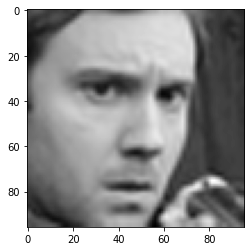

In [380]:
plt.imshow(facialExpression_df[' pixels'][0], cmap = 'gray')

### VISUALIZACION DE LAS IMAGENES Y CORRESPONDIENTE ETIQUETA

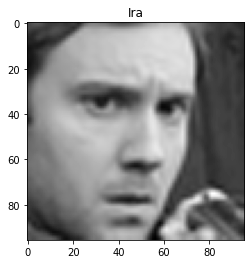

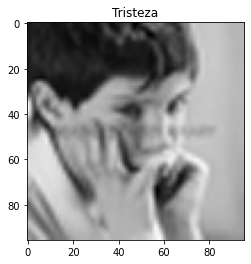

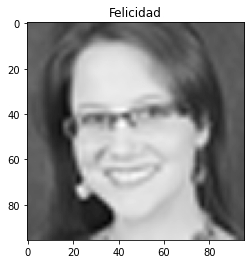

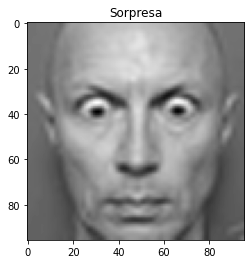

In [381]:
emotions = [0, 1, 2, 3, 4]

for i in emotions: 
    data = facialExpression_df[facialExpression_df['emotion'] == i][:1]
    img = data[' pixels'].item()
    img = img.reshape(96, 96)
    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap = 'gray')

### TAREA 13
* Representar un grafico de barras para averiguar cuantas imagenes estan presentes por cada emocion

In [382]:
facialExpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [383]:
facialExpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

<AxesSubplot:ylabel='emotion'>

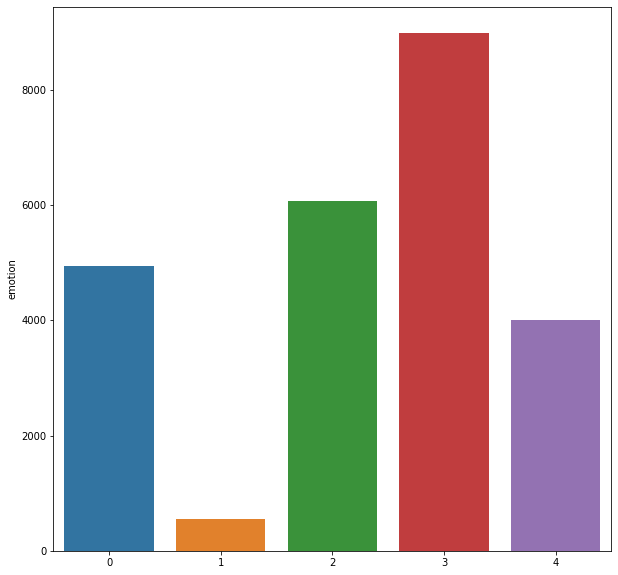

In [384]:
plt.figure(figsize = (10, 10))
sns.barplot(x = facialExpression_df.emotion.value_counts().index,
    y = facialExpression_df.emotion.value_counts())

### PREPARACION DE LOS DATOS Y AUMENTACION DE LAS IMAGENES

In [385]:
from keras.utils import to_categorical

X = facialExpression_df[' pixels']
y = to_categorical(facialExpression_df['emotion'])

In [386]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [387]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [388]:
X.shape[0]

24568

In [389]:
# El metodo stack apila toda la informacion en el axis = 0
X = np.stack(X, axis = 0)
X = X.reshape(X.shape[0], 96, 96, 1)

print("X Shape: {}".format(X.shape))
print("y Shape: {}".format(y.shape))

X Shape: (24568, 96, 96, 1)
y Shape: (24568, 5)


In [390]:
# Dividir el dataframe en conjunto de entrenamiento, test y validacion
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, shuffle = True)

In [391]:
print("x_val Shape: {}".format(x_val.shape))
print("y_val Shape: {}".format(y_val.shape))

x_val Shape: (1228, 96, 96, 1)
y_val Shape: (1228, 5)


In [392]:
print("x_test Shape: {}".format(x_test.shape))
print("y_test Shape: {}".format(y_test.shape))

x_test Shape: (1229, 96, 96, 1)
y_test Shape: (1229, 5)


In [393]:
print("x_train Shape: {}".format(x_train.shape))
print("y_train Shape: {}".format(y_train.shape))

x_train Shape: (22111, 96, 96, 1)
y_train Shape: (22111, 5)


In [394]:
# Pre procesado de Imagenes
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

# Miramos el x_train como los pixeles estan en la escala de 0 y 1 
# 0 = pixel de color negro
# 1 = pixel de color blanco
# 0 < p < 1 = pixel en escala de grises
x_train

array([[[[0.14030564],
         [0.1434462 ],
         [0.14875972],
         ...,
         [0.16862746],
         [0.16862746],
         [0.16862746]],

        [[0.1407984 ],
         [0.14378399],
         [0.14887552],
         ...,
         [0.16851866],
         [0.16849928],
         [0.16848959]],

        [[0.14173548],
         [0.14454752],
         [0.14941406],
         ...,
         [0.16830109],
         [0.16824293],
         [0.16821384]],

        ...,

        [[0.18782169],
         [0.18884803],
         [0.19044118],
         ...,
         [0.24151528],
         [0.23958392],
         [0.23838848]],

        [[0.18782169],
         [0.18884803],
         [0.19044118],
         ...,
         [0.2420172 ],
         [0.23993507],
         [0.23866421]],

        [[0.18782169],
         [0.18884803],
         [0.19044118],
         ...,
         [0.24229239],
         [0.24011871],
         [0.23880209]]],


       [[[0.48769215],
         [0.4520133 ],
         [0.39

In [242]:
# Fíjate que "Brightness_range"
# 1.0 no afecta al brillo de la imagen 
# números más pequeños que 1.0 oscurecen la imagen [0.5, 1.0]
# números más grandes que 1.0 iluminan la imagen [1.0, 1.5] 

In [395]:
train_datagen = ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.5],
    fill_mode = "nearest"
)

### CONSTRUIR Y ENTRENAR MODELO DE DEEP LEARNING PARA LA CLASIFICACION DE EXPRESIONES FACIALES

In [418]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - Fase
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', 
    kernel_initializer = glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides = (2, 2))(X)

# 2 - Fase
X = residual_block(X, filter= [64, 64, 256], stage= 2)

# 3 - Fase
X = residual_block(X, filter= [128, 128, 512], stage= 3)

# 4 - Fase
X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Average_Pooling')(X)

# Capa Final
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', 
    kernel_initializer = glorot_uniform(seed = 0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')
model_2_emotion.summary()


Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_29 (ZeroPadding  (None, 102, 102, 1)  0          ['input_29[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_29[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']           

In [419]:
# Entrenar la red
model_2_emotion.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', 
    metrics = ['accuracy'])

In [420]:
# Recordemos que el primer modelo de puntos faciales claves se guardo con:
# FacialKeyPoints_weights.hdf4 and FacialKeyPoints-model.json

# Usamos la parada temprana para salir del entrenamiento si el  error de validacion
# no decrece despues de cierto numero de epochs (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

# Guardamos el mejor modelo con menor error de validacion
checkpointer = ModelCheckpoint(filepath = "../models/emotion_ia/FacialExpression_weights.hdf4", 
    verbose = 1, save_best_only = True)

In [421]:
history = model_2_emotion.fit(train_datagen.flow(x_train, y_train),
    batch_size = 64,
    validation_data = (x_val, y_val),
    steps_per_epoch = len(x_train) // 64,
    epochs = 40, callbacks = [checkpointer, earlystopping]    
)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
345/345 [==============================] - ETA: 0s - loss: 1.6664 - accuracy: 0.3499WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x3105b6430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from inf to 1.49202, saving model to ../models/emotion_ia/FacialExpression_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x310a41f70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x310a41f70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x310a41f70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 94s 241ms/step - loss: 1.6664 - accuracy: 0.3499 - val_loss: 1.4920 - val_accuracy: 0.2964
Epoch 2/40
345/345 [==============================] - ETA: 0s - loss: 1.5613 - accuracy: 0.3567
Epoch 2: val_loss did not improve from 1.49202
345/345 [==============================] - 67s 192ms/step - loss: 1.5613 - accuracy: 0.3567 - val_loss: 2.5354 - val_accuracy: 0.3542
Epoch 3/40
345/345 [==============================] - ETA: 0s - loss: 1.4988 - accuracy: 0.3685
Epoch 3: val_loss improved from 1.49202 to 1.40038, saving model to ../models/emotion_ia/FacialExpression_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3358d9ca0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.aut

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3358d9ca0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x3358d9ca0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 82s 239ms/step - loss: 1.4988 - accuracy: 0.3685 - val_loss: 1.4004 - val_accuracy: 0.3697
Epoch 4/40
345/345 [==============================] - ETA: 0s - loss: 1.4513 - accuracy: 0.3676
Epoch 4: val_loss improved from 1.40038 to 1.39197, saving model to ../models/emotion_ia/FacialExpression_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 80s 232ms/step - loss: 1.4513 - accuracy: 0.3676 - val_loss: 1.3920 - val_accuracy: 0.3868
Epoch 5/40
345/345 [==============================] - ETA: 0s - loss: 1.4708 - accuracy: 0.3523
Epoch 5: val_loss did not improve from 1.39197
345/345 [==============================] - 67s 193ms/step - loss: 1.4708 - accuracy: 0.3523 - val_loss: 1.3954 - val_accuracy: 0.3705
Epoch 6/40
345/345 [==============================] - ETA: 0s - loss: 1.4274 - accuracy: 0.3484
Epoch 6: val_loss did not improve from 1.39197
345/345 [==============================] - 65s 188ms/step - loss: 1.4274 - accuracy: 0.3484 - val_loss: 1.4933 - val_accuracy: 0.3542
Epoch 7/40
345/345 [==============================] - ETA: 0s - loss: 1.4314 - accuracy: 0.3659
Epoch 7: val_loss did not improve from 1.39197
345/345 [==============================] - 65s 187ms/step - loss: 1.4314 - accuracy: 0.3659 - val_loss: 1.9348 - val_accuracy: 0.2744
Epoch 8/40
345/345 [===============

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 85s 245ms/step - loss: 1.4275 - accuracy: 0.3694 - val_loss: 1.3739 - val_accuracy: 0.3844
Epoch 10/40
345/345 [==============================] - ETA: 0s - loss: 1.4101 - accuracy: 0.3741
Epoch 10: val_loss improved from 1.37394 to 1.31230, saving model to ../models/emotion_ia/FacialExpression_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2dd9e4d30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2dd9e4d30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2dd9e4d30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 91s 263ms/step - loss: 1.4101 - accuracy: 0.3741 - val_loss: 1.3123 - val_accuracy: 0.4389
Epoch 11/40
345/345 [==============================] - ETA: 0s - loss: 1.3772 - accuracy: 0.3990
Epoch 11: val_loss did not improve from 1.31230
345/345 [==============================] - 65s 188ms/step - loss: 1.3772 - accuracy: 0.3990 - val_loss: 1.4114 - val_accuracy: 0.3111
Epoch 12/40
345/345 [==============================] - ETA: 0s - loss: 1.3608 - accuracy: 0.4052
Epoch 12: val_loss did not improve from 1.31230
345/345 [==============================] - 64s 186ms/step - loss: 1.3608 - accuracy: 0.4052 - val_loss: 1.4187 - val_accuracy: 0.3078
Epoch 13/40
345/345 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.4185
Epoch 13: val_loss did not improve from 1.31230
345/345 [==============================] - 64s 186ms/step - loss: 1.3393 - accuracy: 0.4185 - val_loss: 1.3196 - val_accuracy: 0.4226
Epoch 14/40
345/345 [========

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0482ee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x2a0482ee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 84s 243ms/step - loss: 1.2970 - accuracy: 0.4383 - val_loss: 1.3083 - val_accuracy: 0.4699
Epoch 15/40
345/345 [==============================] - ETA: 0s - loss: 1.3080 - accuracy: 0.4370
Epoch 15: val_loss did not improve from 1.30831
345/345 [==============================] - 64s 185ms/step - loss: 1.3080 - accuracy: 0.4370 - val_loss: 1.4301 - val_accuracy: 0.3542
Epoch 16/40
345/345 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.4494
Epoch 16: val_loss improved from 1.30831 to 1.13513, saving model to ../models/emotion_ia/FacialExpression_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 83s 239ms/step - loss: 1.2855 - accuracy: 0.4494 - val_loss: 1.1351 - val_accuracy: 0.5098
Epoch 17/40
345/345 [==============================] - ETA: 0s - loss: 1.2778 - accuracy: 0.4618
Epoch 17: val_loss did not improve from 1.13513
345/345 [==============================] - 64s 186ms/step - loss: 1.2778 - accuracy: 0.4618 - val_loss: 1.3973 - val_accuracy: 0.4601
Epoch 18/40
345/345 [==============================] - ETA: 0s - loss: 1.2899 - accuracy: 0.4609
Epoch 18: val_loss did not improve from 1.13513
345/345 [==============================] - 64s 186ms/step - loss: 1.2899 - accuracy: 0.4609 - val_loss: 1.2685 - val_accuracy: 0.4959
Epoch 19/40
345/345 [==============================] - ETA: 0s - loss: 1.2571 - accuracy: 0.4749
Epoch 19: val_loss did not improve from 1.13513
345/345 [==============================] - 64s 186ms/step - loss: 1.2571 - accuracy: 0.4749 - val_loss: 3.7350 - val_accuracy: 0.4226
Epoch 20/40
345/345 [========

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28fe2bdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 86s 250ms/step - loss: 1.2481 - accuracy: 0.4868 - val_loss: 1.0482 - val_accuracy: 0.6010
Epoch 24/40
345/345 [==============================] - ETA: 0s - loss: 1.2349 - accuracy: 0.4935
Epoch 24: val_loss did not improve from 1.04824
345/345 [==============================] - 65s 187ms/step - loss: 1.2349 - accuracy: 0.4935 - val_loss: 1.4658 - val_accuracy: 0.3070
Epoch 25/40
345/345 [==============================] - ETA: 0s - loss: 1.2302 - accuracy: 0.4931
Epoch 25: val_loss did not improve from 1.04824
345/345 [==============================] - 65s 188ms/step - loss: 1.2302 - accuracy: 0.4931 - val_loss: 1.1408 - val_accuracy: 0.6002
Epoch 26/40
345/345 [==============================] - ETA: 0s - loss: 1.2189 - accuracy: 0.4911
Epoch 26: val_loss did not improve from 1.04824
345/345 [==============================] - 64s 186ms/step - loss: 1.2189 - accuracy: 0.4911 - val_loss: 1.3101 - val_accuracy: 0.4153
Epoch 27/40
345/345 [========

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28ffab8b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28ffab8b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 85s 246ms/step - loss: 1.1978 - accuracy: 0.5067 - val_loss: 1.0402 - val_accuracy: 0.6173
Epoch 29/40
345/345 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.5004
Epoch 29: val_loss did not improve from 1.04024
345/345 [==============================] - 65s 187ms/step - loss: 1.2096 - accuracy: 0.5004 - val_loss: 1.0505 - val_accuracy: 0.6034
Epoch 30/40
345/345 [==============================] - ETA: 0s - loss: 1.1748 - accuracy: 0.5100
Epoch 30: val_loss did not improve from 1.04024
345/345 [==============================] - 65s 189ms/step - loss: 1.1748 - accuracy: 0.5100 - val_loss: 1.3133 - val_accuracy: 0.4788
Epoch 31/40
345/345 [==============================] - ETA: 0s - loss: 1.2108 - accuracy: 0.5044
Epoch 31: val_loss did not improve from 1.04024
345/345 [==============================] - 64s 187ms/step - loss: 1.2108 - accuracy: 0.5044 - val_loss: 1.1508 - val_accuracy: 0.5806
Epoch 32/40
345/345 [========

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x140943c10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x140943c10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 84s 244ms/step - loss: 1.1875 - accuracy: 0.5166 - val_loss: 0.9518 - val_accuracy: 0.6270
Epoch 33/40
345/345 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.5207
Epoch 33: val_loss improved from 0.95184 to 0.87365, saving model to ../models/emotion_ia/FacialExpression_weights.hdf4
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28ffab8b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28ffab8b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x28ffab8b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


INFO:tensorflow:Assets written to: ../models/emotion_ia/FacialExpression_weights.hdf4/assets


345/345 [==============================] - 81s 233ms/step - loss: 1.1672 - accuracy: 0.5207 - val_loss: 0.8736 - val_accuracy: 0.6694
Epoch 34/40
345/345 [==============================] - ETA: 0s - loss: 1.1711 - accuracy: 0.5204
Epoch 34: val_loss did not improve from 0.87365
345/345 [==============================] - 65s 188ms/step - loss: 1.1711 - accuracy: 0.5204 - val_loss: 1.1626 - val_accuracy: 0.5928
Epoch 35/40
345/345 [==============================] - ETA: 0s - loss: 1.1644 - accuracy: 0.5196
Epoch 35: val_loss did not improve from 0.87365
345/345 [==============================] - 65s 187ms/step - loss: 1.1644 - accuracy: 0.5196 - val_loss: 1.0779 - val_accuracy: 0.5684
Epoch 36/40
345/345 [==============================] - ETA: 0s - loss: 1.1826 - accuracy: 0.5113
Epoch 36: val_loss did not improve from 0.87365
345/345 [==============================] - 65s 188ms/step - loss: 1.1826 - accuracy: 0.5113 - val_loss: 1.0511 - val_accuracy: 0.5774
Epoch 37/40
345/345 [========

In [260]:
# Guardar la arquitectura del modelo en un JSON 
model_json = model_2_emotion.to_json()

with open("../models/emotion_ia/json/FacialExpression-model.json", "w") as json_file:
    json_file.write(model_json)

### TAREA 15
* Experimentar con varios tamaños de lote, paciencia, optimizadores, y arquitectura de red para mejorar el rendimiento de la red

### EVALUAR LA EFICACIA DEL MODELO CLASIFICADOR DE EXPRESIONES FACIALES ENTRENADO

In [267]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_saveModel = json_file.read()

# Cargamos la arquitectura del modelo
model_2_emotion = tf.keras.models.model_from_json(json_saveModel)
model_2_emotion.load_weights('../models/emotion_ia/FacialExpression_weights.hdf4')
model_2_emotion.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

2022-08-09 15:23:41.725959: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../models/FacialExpression_weights.hdf4: FAILED_PRECONDITION: ../models/FacialExpression_weights.hdf4; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [268]:
score = model_2_emotion.evaluate(x_test, y_test)
print('Accuracy en fase de test: {}'.format(score[1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - 2s 44ms/step - loss: 0.8746 - accuracy: 0.6542
Accuracy en fase de test: 0.6541904211044312


In [422]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [423]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

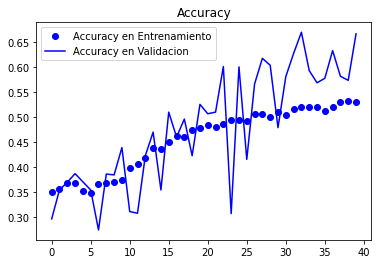

In [424]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Accuracy en Entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label = 'Accuracy en Validacion')
plt.title('Accuracy')
plt.legend()

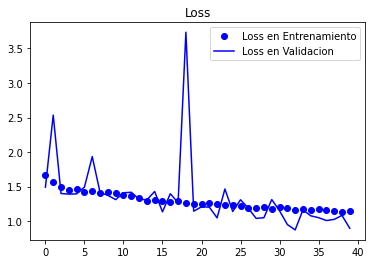

In [425]:
plt.plot(epochs, loss, 'bo', label = 'Loss en Entrenamiento')
plt.plot(epochs, val_loss, 'b', label = 'Loss en Validacion')
plt.title('Loss')
plt.legend()

In [426]:
predicted_classes = np.argmax(model_2_emotion.predict(x_test), axis = -1)
y_true = np.argmax(y_test, axis = -1)

y_true.shape

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - 4s 56ms/step


(1229,)

<AxesSubplot:>

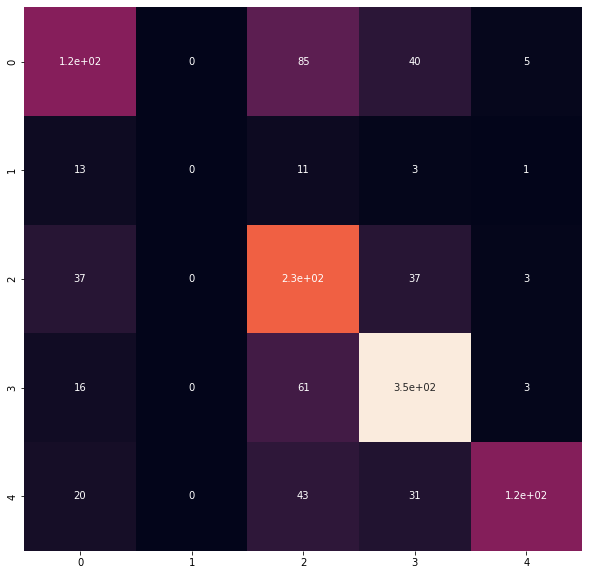

In [427]:
# Matriz de confusion
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

### TAREA 16
* Mostrar una matriz de 25 imagenes junto con su etiqueta predicha / verdadera
* Mostrar el informe de clasificacion y analizar la precision y la recuperacion

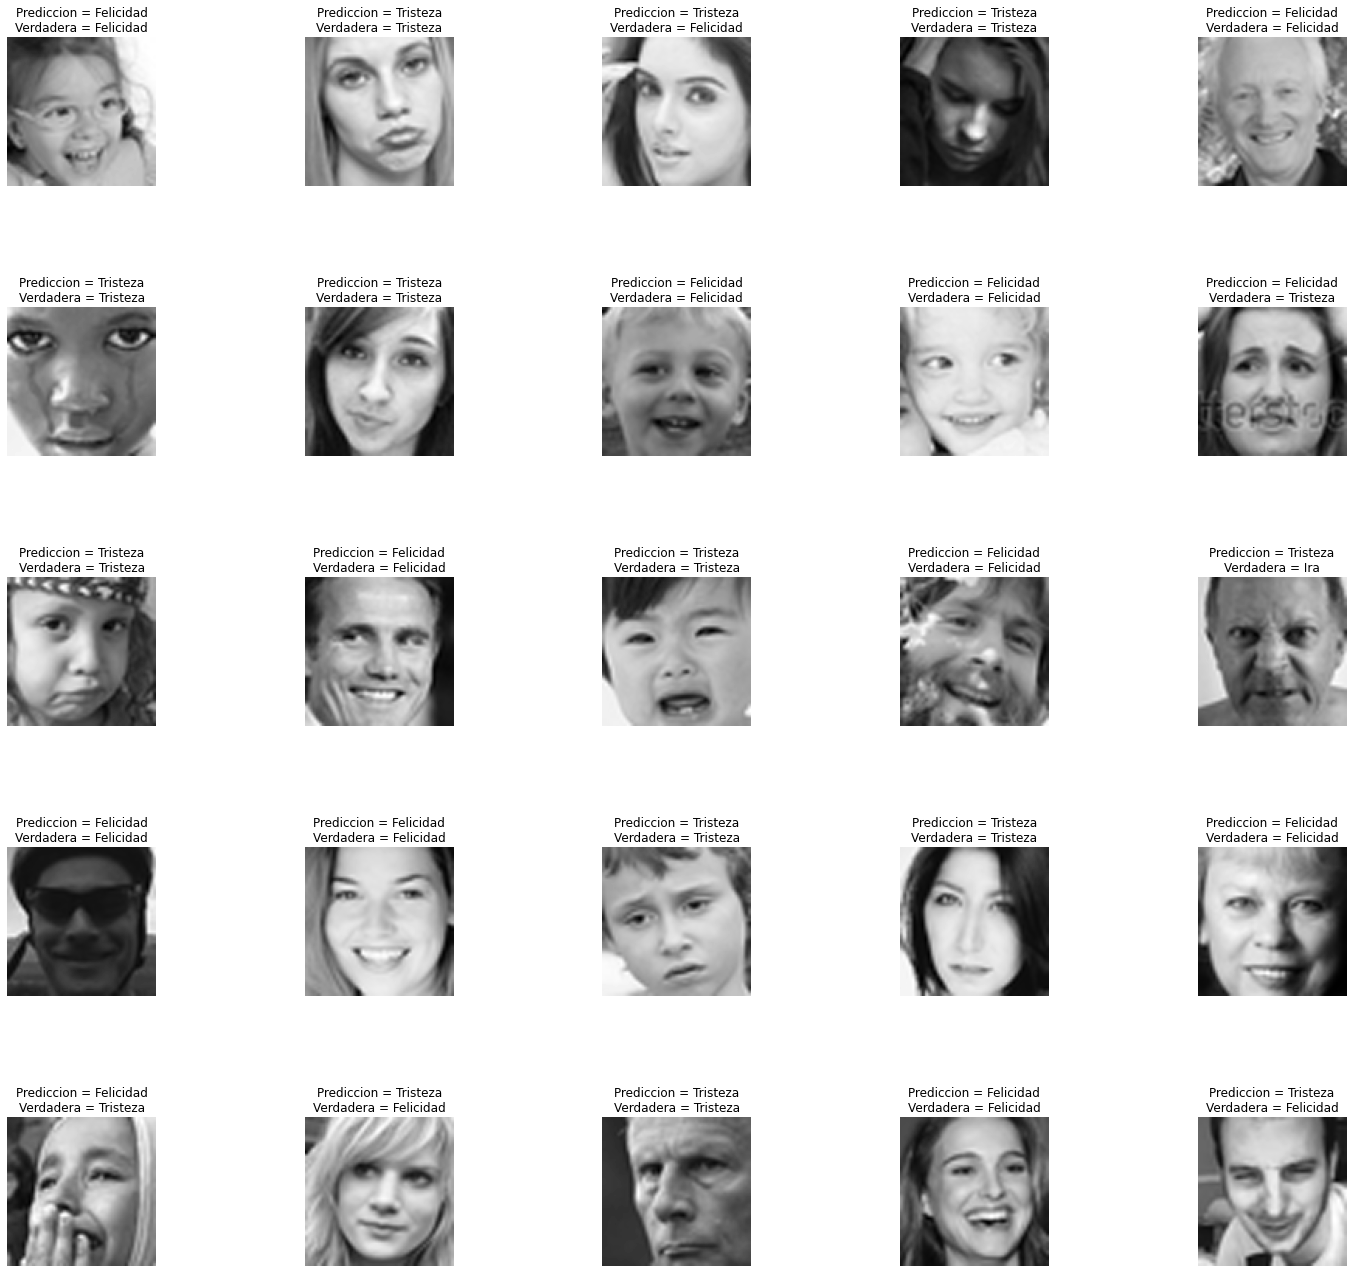

In [428]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(x_test[i].reshape(96, 96), cmap = 'gray')
    axes[i].set_title('Prediccion = {}\nVerdadera = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')    # QUITA LOS EJES

plt.subplots_adjust(wspace = 1)

In [429]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.58      0.48      0.52       248
           1       0.00      0.00      0.00        28
           2       0.54      0.75      0.63       311
           3       0.76      0.81      0.79       431
           4       0.91      0.55      0.69       211

    accuracy                           0.67      1229
   macro avg       0.56      0.52      0.52      1229
weighted avg       0.68      0.67      0.66      1229



/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

### COMBINAR AMBOS MODELOS (1) DETECCION DE PUNTOS CLAVE FACIALES Y (2) DE EXPRESIONES FACIALES

In [430]:
def predict(x_test):
    # Hacemos la prediccion con el modelo de puntos clave
    df_predict = model_1_facialKeyPoints.predict(x_test)

    # Hacemos la prediccion con el modelo de emociones
    df_emotion = np.argmax(model_2_emotion.predict(x_test), axis = -1)

    # Redimensionamos el array de (856, ) a (856, 1)
    df_emotion = np.expand_dims(df_emotion, axis = 1)

    # Convertimos las predicciones en un dataframe 
    df_predict = pd.DataFrame(df_predict, columns = columns)

    # Añadimos la emocion al dataframe de predicciones
    df_predict['emotion'] = df_emotion

    return df_predict

In [431]:
df_predict = predict(x_test)
df_predict.head()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - 2s 49ms/step


left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          63.611855          39.489674           31.913488   
1          66.987572          45.781693           30.332260   
2          61.855679          36.038963           33.659363   
3          31.887247          35.694599           61.328220   
4          61.723434          40.364765           35.762596   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           39.564072                58.389957                39.792866   
1           46.384598                60.423996                45.760799   
2           34.546745                56.427410                36.459835   
3           38.772720                38.394924                37.229401   
4           41.277943                57.637871                41.013927   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                69.640495                40.113457                 37.832649   
1                74.142372                45.318375                 37.031052   
2                68.357918                36.928566                 38.659164   
3                25.876493                36.194702                 55.009697   
4                66.449669                40.248055                 40.259502   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 39.947231  ...   52.733444            61.312725   
1                 46.167732  ...   46.479111            64.544098   
2                 35.500729  ...   56.780563            56.872440   
3                 39.139683  ...   58.950550            30.396378   
4                 41.753361  ...   55.508175            58.865807   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            69.385406             33.932800             69.583519   
1            46.421143             33.718254             47.363537   
2            72.785889             32.463501             71.453514   
3            75.184593             55.700665             77.701836   
4            62.408131             36.909023             63.088318   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               49.055088               66.472900                  49.113121   
1               48.290359               47.171970                  48.902050   
2               42.288967               71.724388                  42.165855   
3               43.326313               76.289597                  43.040199   
4               48.358925               63.892525                  48.505051   

   mouth_center_bottom_lip_y  emotion  
0                  74.755707        3  
1                  47.535164        2  
2                  78.283966        2  
3                  81.171410        2  
4                  66.775894        3  

[5 rows x 31 columns]

### TAREA 17
* Representamos una matriz de 16 imagenes junto con emocion predicha y sus puntos faciales

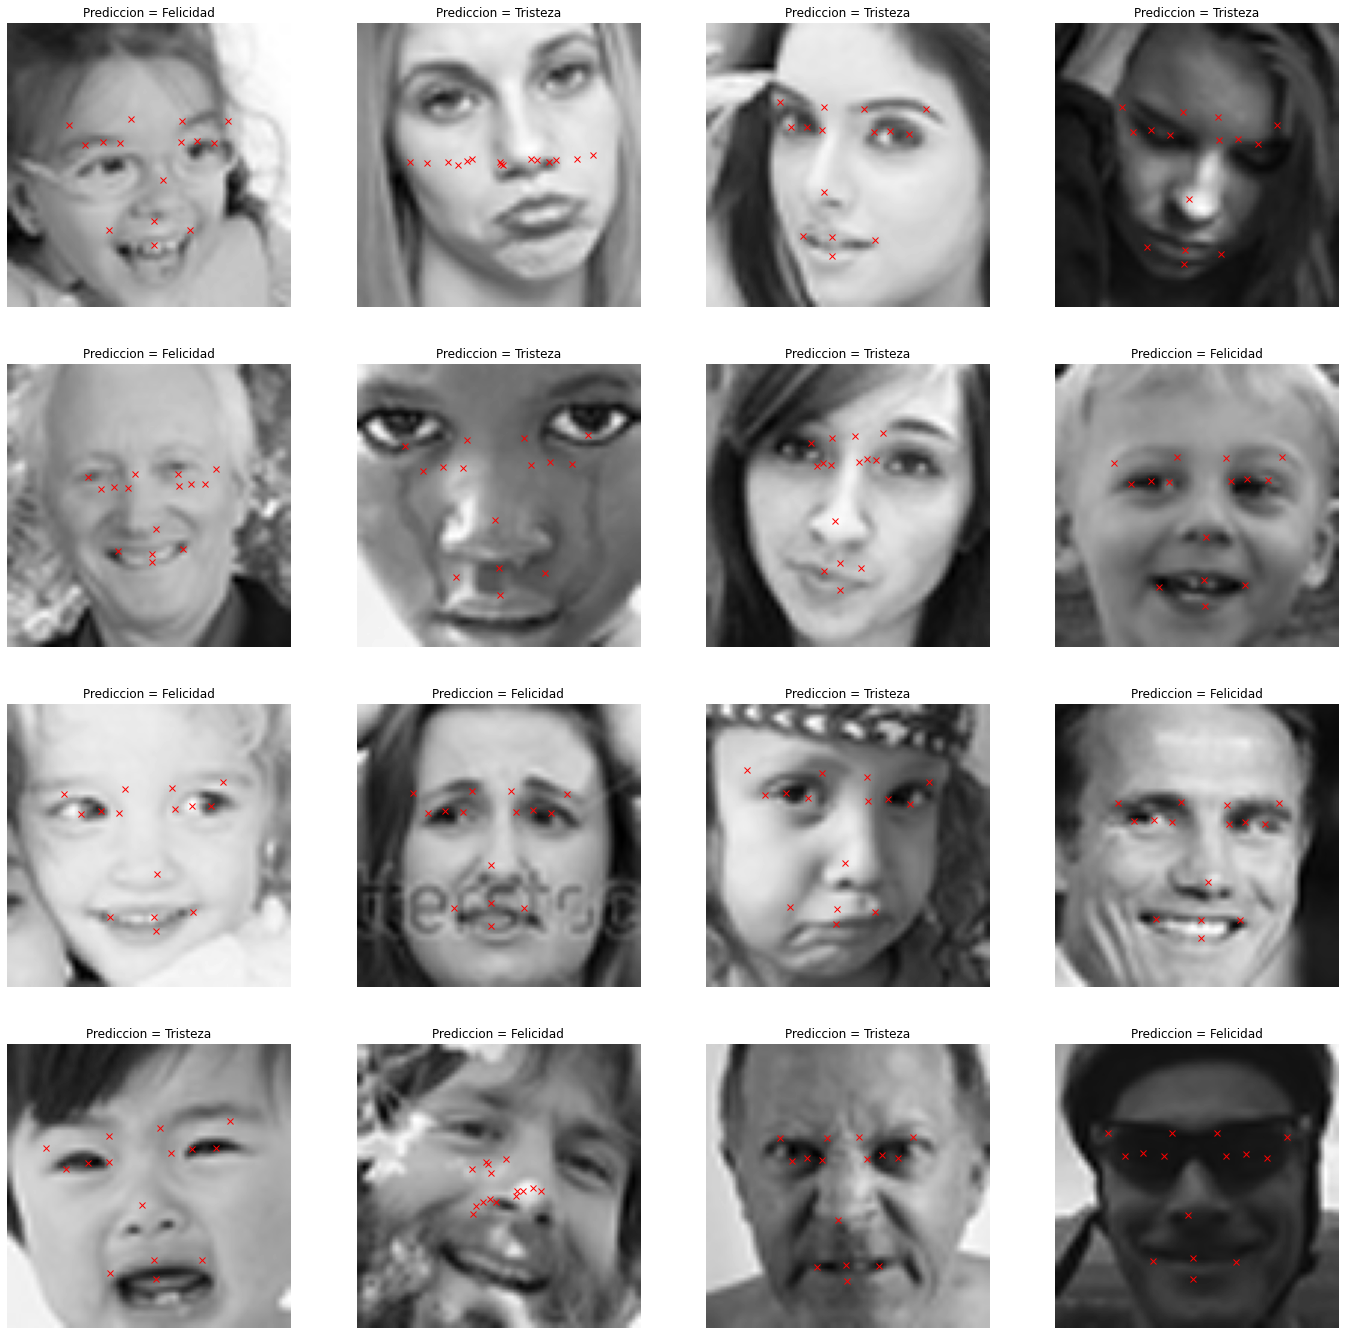

In [432]:
# Representamos las imágenes de test junto con los puntos clave y emociones

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(x_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediccion = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

### DESPLEGAR LOS MODELOS ENTRENADOS

#### GUARDAR EL MODELO ENTRENADO

Despliegue del Modelo utilizando TENSORFLOW SERVING:

* Supongamos que ya tenemos entrenado nuestro modelo y esta generando buenos resultados en los datos de prueba
* Ahora, queremos integrar nuestro modelo de Tensorflow entrenado en una aplicacion web e implementar el modelo en un entorno de nivel de produccion
* El siguiente objetivo se puede obtener utilizando TensorFlow Serving
* Con la ayuda de TensorFlow Serving podemos implementar facilmente nuevos algoritmos para hacer predicciones
* Para publicar el modelo entrenado con TensorFlow Serving necesitamos guardar el modelo en el formato que sea adecuado para entregar usando TensorFlow Serving
* El modelo tendra un numero de version y se guardara en un directorio estructurado
* Una vez que se guarda el modelo ahora podemos usar TensorFlow Serving para comenzar a realizar solicitures de inferencia utilizando una version especifica de nuestro modelo entrenado "servible"

Ejecutar TENSORFLOW SERVING:

* Parametros importantes:
    * rest_api_port: puerto que usaremos para las peticiones REST
    * model_name: la URL que usaremos para las peticiones REST, se puede elegir cualquier nombre
    * model_base_path: la ruta al directorio donde hemos guardado el modelo
* REST es una reinterpretacion del protocolo HTTP donde los comandos http tienen un significado semantico

Hacer peticiones con TENSORFLOW SERVING:

* Para hacer predicciones usando TensorFlow Serving, necesitamos pasar las solicitudes de inferencia (datos de nuestra imagen) como un objeto JSON
* Luego, usamos la libreria requests de Python para realizar una solicitud por POST al modelo implementado, pasando el objeto JSON que contiene las solicitudes de inferencia (datos de nuestra imagen)
* Finalmente, obtenemos la prediccion de la solicitud por POST realizada al modelo implementado y luego usamos la funcion argmax para encontrar la clase predicha

RESUMEN:

* Ahora necesitamos guardar nuestro modelo entrenado y debe guardarse en un formato `SaveModel`
* El modelo tendra un numero de version y se guardara en un directorio estructurado
* `tf.saved_model.save` es una funcion que se usa para crear un modelo guardado que es adecuado para publicar con TensorFlow Serving
* Una vez guardado el modelo, ahora podemos usar TensorFlow Serving para comenzar a realizar solicitudes de inferencia utilizando una version especifica de nuestro modelo entrenado "servible"
* Utilizaremos `SavedModel` para guardar y cargar nuestro modelo: variables, el grafico y los metadatos del grafico
* Mas Info: https://www.tensorflow.org/guide/saved_model

In [292]:
import json 
from tensorflow.keras import backend as K

def deploy(directory, model):
    MODEL_DIR = directory
    version = 1

    # Juntamos el directorio del temp model con la version elegida
    # El resultado sera = '\tmp\version_number'
    export_path = os.path.join(MODEL_DIR, str(version))
    print('export_path = {}\n'.format(export_path))

    # Guardemos el modelo con saved_model.save()
    # Si el directorio existe, debemos borrarlo con '!rm'
    # rm elimina cada fichero especificado usando la consola de comandos
    if os.path.isdir(export_path):
        print('\nAlready saved a model, cleaning up\n')
        !rm -r {export_path}

    tf.saved_model.save(model, export_path)

    os.environ["MODEL_DIR"] = MODEL_DIR

### PUBLICAR EL MODELO CON TENSORFLOW SERVING

In [310]:
import sys

# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

SUDO_IF_NEEDED

'sudo'

In [316]:
import getpass

password = getpass.getpass()
command = "echo 'deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal'"
os.popen(command, 'w').write(password+'\n')


12

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
